# What kind of doggo is that? Classifying Dog Breeds using Convolutional Neural Networks

## Task 5: Basic Convolutional Neural Network

In this task, we will implement our very own model to try and predict these dog breeds accurately!

In [1]:
import matplotlib
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import matplotlib.pyplot as plt
plt.style.use('ggplot')

from sklearn.model_selection import train_test_split
import tensorflow as tf
import numpy as np
import glob
import os

from helpers import plot_cm

In [2]:
filenames = glob.glob('Data/*/*.jpg')

In [3]:
labels = [x.split('/')[1] for x in filenames]

In [4]:
breeds = np.unique(labels)
breeds_to_label = {breed: ix for ix, breed in enumerate(breeds)}
breeds_to_label

{'american_bulldog': 0,
 'boxer': 1,
 'english_cocker_spaniel': 2,
 'samoyed': 3,
 'scottish_terrier': 4,
 'staffordshire_bull_terrier': 5}

In [5]:
filenames_train, filenames_val, y_train, y_val = train_test_split(filenames, labels, stratify=labels, random_state=8)

In [6]:
# build a lookup table
table = tf.lookup.StaticHashTable(
    initializer=tf.lookup.KeyValueTensorInitializer(
        keys=tf.constant(breeds.tolist()),
        values=tf.constant(np.arange(len(breeds)).tolist()),
    ),
    default_value=tf.constant(-1)
)

# now let us do a lookup
input_tensor = tf.constant(['beagle'], dtype=tf.string)
table.lookup(input_tensor)

<tf.Tensor: shape=(1,), dtype=int32, numpy=array([-1], dtype=int32)>

In [7]:
def reshape_rescale_image(image, height=96, width=96):
    image = tf.cast(image, tf.float32)/255.
    image = tf.image.resize_with_pad(image, target_height=height, target_width=width)
    return image

def parse_image(file_path):
    label = tf.strings.split(file_path, os.sep)[-2]
    image = tf.io.decode_image(tf.io.read_file(file_path), channels=3)
    image.set_shape([None, None, 3])
    return reshape_rescale_image(image), table.lookup(label)

In [8]:
dataset_train = tf.data.Dataset.list_files(filenames_train)
dataset_train = dataset_train.map(parse_image).shuffle(8).batch(8).prefetch(buffer_size=400).cache('dataset_train.cache')

dataset_val = tf.data.Dataset.list_files(filenames_val)
dataset_val = dataset_val.map(parse_image).batch(8).prefetch(buffer_size=100)

In [14]:
num_classes = len(breeds)

model = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomContrast(0.2),
    tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Conv2D(32, 3, padding = 'same', activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv2D(64, 3, padding = 'same', activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv2D(128, 3, padding = 'same', activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation = 'relu'),
    tf.keras.layers.Dense(num_classes)
])

In [15]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [16]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor = 'val_loss',
    patience = 3,
    restore_best_weights= True
)

epochs = 20

history = model.fit(
dataset_train, 
validation_data = dataset_val,
epochs = epochs,
callbacks = [early_stopping_callback])

Epoch 1/20
112/112 [==============================] - 30s 272ms/step - loss: 1.7570 - accuracy: 0.2489 - val_loss: 1.7328 - val_accuracy: 0.2416
Epoch 2/20
112/112 [==============================] - 30s 270ms/step - loss: 1.6595 - accuracy: 0.2803 - val_loss: 1.6990 - val_accuracy: 0.2852
Epoch 3/20
112/112 [==============================] - 30s 272ms/step - loss: 1.6080 - accuracy: 0.3049 - val_loss: 1.6375 - val_accuracy: 0.3456
Epoch 4/20
112/112 [==============================] - 32s 285ms/step - loss: 1.5606 - accuracy: 0.3475 - val_loss: 1.6545 - val_accuracy: 0.3456
Epoch 5/20
112/112 [==============================] - 32s 286ms/step - loss: 1.5398 - accuracy: 0.3767 - val_loss: 1.5928 - val_accuracy: 0.3389
Epoch 6/20
112/112 [==============================] - 34s 302ms/step - loss: 1.5122 - accuracy: 0.3924 - val_loss: 1.5653 - val_accuracy: 0.3523
Epoch 7/20
112/112 [==============================] - 30s 266ms/step - loss: 1.4791 - accuracy: 0.4036 - val_loss: 1.5621 - val_ac

In [17]:
preds, true = [], []
for x, y in dataset_val:
    true.extend([breeds[x] for x in y.numpy().tolist()])
    predictions = np.argmax(model.predict(x).tolist() , axis = 1) # TODO
    preds.extend([breeds[x] for x in predictions])

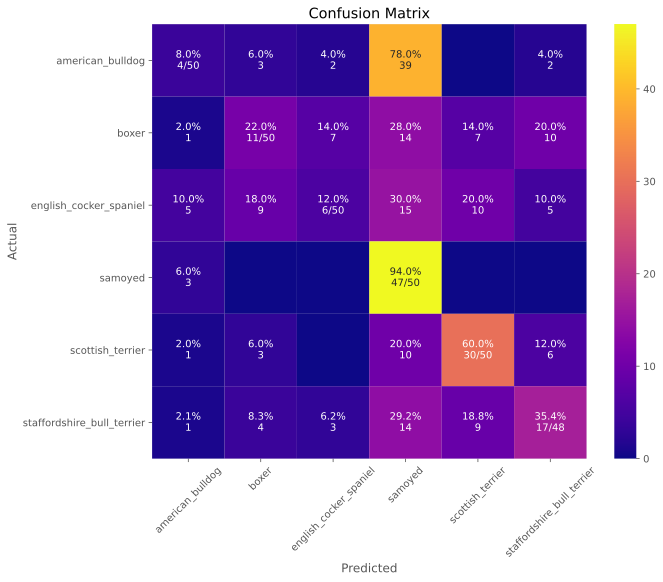

In [18]:
plot_cm(true, preds)